- What are the initial velocities?: restart with predefined velocities
- Why are the positions negative after first iteration (MIC?) ? yes looks like it (addition of cell length gives same result as fractional)

- Why jump the coordinates from step 0 to step 1 and back from 1 to 2?
velocities seem to be ok and step 2 agrees with step 2 from python

Is agreement between curves within numerical precision?

## NVE-MD

In [1]:
from profess_calculator import PROFESS2
import profess_io as pio
from cpmd import initialize_atoms
from ase.md.verlet import VelocityVerlet
from ase import units
import os
import pixiedust
import numpy as np
from matplotlib import pyplot as plt


Pixiedust database opened successfully


In [2]:
# initialize
pos_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step0.dat'
vel_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step0.dat'
cell_param = [[3.97, 0, 0], [0, 3.97, 0], [0, 0, 3.97]]
atoms = initialize_atoms(pos_file, vel_file, cell_param, pos_type='FRAC')

# set parameters for PROFESS calculation
run_dir = '/home/misa/git_repositories/PROFESS/test/ase_singlepoint'
inpt_name = 'sp'
pp_names = ['al_HC.lda.recpot']

In [4]:
# %%pixie_debugger
save_pos = [atoms.get_positions()]
save_vel = [atoms.get_velocities()]
save_forces = []
total_energy = []
e_kin = []

e_kin_step = atoms.get_kinetic_energy()
e_kin.append(e_kin_step)
atoms.set_calculator(PROFESS2(run_dir, inpt_name, pp_names, atoms))
# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1*units.fs, logfile='/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_log')  # 1 fs time step.
# run only for one step
f=dyn.run(515)

# # save_pos.append(atoms.get_positions())
# # save_vel.append(atoms.get_velocities())
# # # forces and energies belong to step n-1
# # e_tot_step = pio.parse_out_file(os.path.join(run_dir, inpt_name+'.out'), 'TOTAL ENERGY')    
# # total_energy.append(e_kin_step+e_tot_step)
# # save_forces.append(atoms._calc.forces)
# # total_energy = np.array(total_energy)
# # e_kin = np.array(e_kin)

In [ ]:
# # %%pixie_debugger
# save_pos = [atoms.get_positions()]
# save_vel = [atoms.get_velocities()]
# save_forces = []
# total_energy = []
# e_kin = []
# for n in range(1, 515):
#     # kinetic energy at step n-1
#     e_kin_step = atoms.get_kinetic_energy()
#     e_kin.append(e_kin_step)
#     atoms.set_calculator(PROFESS(run_dir, inpt_name, pp_names, atoms))
#     # We want to run MD with constant energy using the VelocityVerlet algorithm.
#     dyn = VelocityVerlet(atoms, 1*units.fs)  # 1 fs time step.
#     # run only for one step
#     f=dyn.run(1)
    
#     save_pos.append(atoms.get_positions())
#     save_vel.append(atoms.get_velocities())
#     # forces and energies belong to step n-1
#     e_tot_step = pio.parse_out_file(os.path.join(run_dir, inpt_name+'.out'), 'TOTAL ENERGY')    
#     total_energy.append(e_kin_step+e_tot_step)
#     save_forces.append(atoms._calc.forces)
# total_energy = np.array(total_energy)
# e_kin = np.array(e_kin)

In [ ]:
total_energy = np.array(total_energy)
e_kin = np.array(e_kin)
fig,ax = plt.subplots(1,3)
ax[0].plot(total_energy)
ax[1].plot(total_energy-e_kin)
ax[2].plot(e_kin)

In [ ]:
# save data
path = '/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_etot_run1step'
path_kin= '/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_ekin_run1step'
np.savetxt(path, total_energy)
np.savetxt(path_kin, e_kin)

In [ ]:
# plot energy vs stepsize for ase and profess

#### compare positions

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import profess_io as pio
from ase import units

In [ ]:
# monitor change of profess structures

def get_coord_atom(structure_array, num_atom, name_coord):
    coord = []
    for s in structure_array:
        coord.append(s[num_atom][name_coord])
    return(coord)

structure_array = []
for pf in range(1, 21):
    structure_array.append(pio.parse_ion_file(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step{pf}.dat'))

In [ ]:
num_atom = 3
num_coord = 2
positions_ase = get_coord_atom(save_pos, num_atom, num_coord)
positions_profess = get_coord_atom(structure_array, num_atom, num_coord)
step = np.arange(1, 21)
fig, ax = plt.subplots(1,1)
plt.rcParams['font.size'] = 20
ax.plot(step, positions_ase[:-1], '-o', label = 'ase')
ax.plot(step[1::2], np.array(positions_profess)[1::2]*3.97, '-o', label = 'profess')
# ax.plot(step[1:], np.array(positions_profess)[1:]*3.97, '-o', label = 'profess')


ax.set_xlabel(r'step $n$')
ax.set_ylabel(r'$R_{I, i}$ (Ang)')
ax.legend()

#### compare velocities

In [ ]:
# velocities from Bohr/aut (PROFESS) -> Ang/ (Ang sqrt(aum/eV)) (ASE)
# Bohr -> Ang = length_in_Bohr*units.Bohr
# aut -> Ang sqrt(aum/eV)
aut2fs = 2.41888433e-2 # go from aut -> fs
aut2aset = aut2fs*units.fs # from aut -> aset (ase time unit)
au_vel2ase_vel = units.Bohr/aut2aset # conversion of velocities in a.u. to native ase units

# get velocities from profess
vel_array = []
for pf in range(1, 21):
    vel_array.append(pio.parse_velocity_file(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step{pf}.dat'))

num_atom = 0
num_coord = 0
velocities_ase = get_coord_atom(np.array(save_vel)/au_vel2ase_vel, num_atom, num_coord)
velocities_profess = get_coord_atom(vel_array, num_atom, num_coord)

step = np.arange(1, 21)

plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,1)

ax.plot(step, velocities_ase[:-1], '-o', label = 'ase')
ax.plot(step, velocities_profess, '-o', label = 'profess')

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_xlabel(r'step $n$')
ax.set_ylabel(r'$v_{I,i}$ (a.u.)')
ax.legend()

#### compare energies

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from ase import units

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/apdft-ofdft-cpmd/')
import profess_io as pio

In [6]:
ekin_ref = pio.parse_out_file('/home/misa/git_repositories/PROFESS/test/md_nve_ref/md_nve.out', 'NVE Kinetic energy')
ekin_ref = np.array(ekin_ref)*units.Ha

epot_ref = pio.parse_out_file('/home/misa/git_repositories/PROFESS/test/md_nve_ref/md_nve.out', 'NVE Potential energy')
epot_ref = np.array(epot_ref)*units.Ha
etotal_ref = epot_ref + ekin_ref

In [7]:
# 1 step MD
path_etot = '/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_etot_run1step'
path_kin= '/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_ekin_run1step'
etot_1step = np.loadtxt(path_etot)
ekin_1step = np.loadtxt(path_kin)

In [8]:
# all step MD
ekin_all = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_log',skiprows=1)

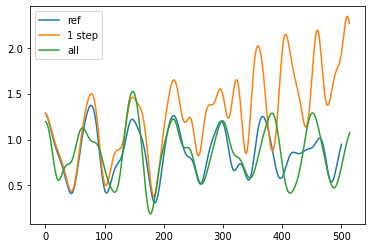

In [9]:
fig, ax = plt.subplots(1,1)
for ekin,l in zip([ekin_ref, ekin_1step, ekin_all[:,3]], ['ref', '1 step', 'all']):
    ax.plot(ekin, label = l)
ax.legend()

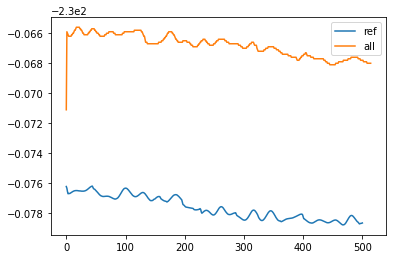

In [11]:
fig, ax = plt.subplots(1,1)
for ekin,l in zip([etotal_ref, ekin_all[:,1]], ['ref', 'all']):
    ax.plot(ekin, label = l)
ax.legend()
# fig, ax = plt.subplots(1,1)
# for ekin,l in zip([etotal_ref, etot_1step, ekin_all[:,1]], ['ref', '1 step', 'all']):
#     ax.plot(ekin, label = l)
# ax.legend()

In [ ]:
# figure out how to get the correct potential energy for every MD step
# compare abinitio start from previous density and from scratch (make sure that indeed start from previous)
# plot energy, e_pot, e_kin for many steps
# make sure that there are no bugs in parsing of files
# explain why1 worse because no cancelling

files for ofdft:
- job.inpt (stays the same during CPMD)
- job.ion (structure: update position, lattice vectors?)
- density (update from CPMD)
- al.lda.recpot (pseudopotentials: stay the same during CPMD)

Which code to do APDFT calculations? (must support crystal structures)
Are local ofdft pseudopotentials compatible with other non-local pseudopotentials?

How to do MD runs in OFDFT for comparison?

How to run NVE, What is NVT coupled with Nose-Hoover?
Why are the positions negative, so close togethcer and different from initial structure?



- get forces, velocities from ofdft during python runtime
- propagate nuclei


            

#### old version

In [ ]:
pos_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step0.dat'
vel_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step0.dat'
for_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/force_step0.dat'
cell_param = [[3.97, 0, 0], [0, 3.97, 0], [0, 0, 3.97]]

work_dir = '/home/misa/git_repositories/PROFESS/test/MD_NVE/sp_ase/'

save_pos = []
save_vel = []

atoms = initialize_atoms(pos_file, vel_file, cell_param)
for n in range(0, 21):
    atoms.set_calculator(OFDFT_calculator(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/force_step{n}.dat', atoms))
    # We want to run MD with constant energy using the VelocityVerlet algorithm.
    dyn = VelocityVerlet(atoms, 1*units.fs)  # 1 fs time step.
    # run only for one step
    f=dyn.run(1)
    
    save_pos.append(atoms.get_positions())
    save_vel.append(atoms.get_velocities())